# Example of Using LTIStateSpaceMPCPyomoOptimization with RAVEN XML Matrices File and SinusoidalForecast
This notebook shows how to create a workflow using a RAVEN generated DMDc XML metadata file with component pieces instead of using the CollectedNextDispatch object.

## Imports

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ORCA.Optimization.LTIStateSpaceMPCPyomoOptimization import LTIStateSpaceMPCPyomoOptimization
from ORCA.RewardForecast.SinusoidalForecast import SinusoidalForecast

## Set up Optimization object

In [2]:
opt_specs = {'t_window': 720.0, 
             'dt': 5.0,
             'solver': 'glpk',
             'matrices': '../tests/data/RAVENDMDc.xml',
             'states': {'order': ['qNPP', 'SOC'],
                        'lb': [0.0, 0.0],
                        'ub': [50.0, 20.0]},
             'control': {'order': ['qC', 'qD'],
                         'lb': [0.0, 0.0],
                         'ub': [20.0, 20.0]},
             'measurements': {'order': ['SOC2'],
                              'lb': [0.0],
                              'ub': [20.0]},
             'objective': {'LMP': {'state_multiplier': [1.0, 0.0],
                                   'control_multiplier': [-1.0, 1.0],
                                   'measurement_multiplier': [0.0]},
                           'sense': 'maximize'}}
optimize = LTIStateSpaceMPCPyomoOptimization(**opt_specs)

## Set up RewardForecast object

In [3]:
reward_specs = {'t_window': 720.0, 
                'dt': 5.0, 
                'amplitude': 20.0,
                'phase': np.pi/4.0, 
                'frequency': 2.0*np.pi/144.0,
                'offset': 40.0}
rewards = SinusoidalForecast(**reward_specs)

## Set up and get results

In [4]:
# specify an initial and end time
initial_time = pd.to_datetime('2022-05-31 04:00:00')
# end_time = pd.to_datetime('2022-06-01 04:00:00')
end_time = pd.to_datetime('2022-06-06 00:05:00')
current_time = initial_time
result_df = None

# initial states
x_init = [50.0, 0.0]

while current_time < end_time:
    current_time += pd.Timedelta(minutes=5)
    # generate reward data
    reward = {'LMP': rewards.gen_reward()}
    # get the next dispatch
    result = optimize.return_next_dispatch(reward, x_init)
    # store optimal results in a DataFrame
    optimal_dict = {'Time': [current_time]}
    # store states
    for i in range(len(opt_specs['states']['order'])):
        optimal_dict[opt_specs['states']['order'][i]] = [result['states'][i]]
    # store control
    for i in range(len(opt_specs['control']['order'])):
        optimal_dict[opt_specs['control']['order'][i]] = [result['control'][i]]
    # store measurements
    for i in range(len(opt_specs['measurements']['order'])):
        optimal_dict[opt_specs['measurements']['order'][i]] = [result['measurements'][i]]
    # store rewards
    optimal_dict['LMP'] = [reward['LMP'][1]]
    optimal = pd.DataFrame(optimal_dict)
    if result_df is None:
        result_df = optimal
    else:
        result_df = pd.concat([result_df, optimal], ignore_index=True)
    # update initial states
    x_init = result['states']

## Look at results

<IPython.core.display.Javascript object>


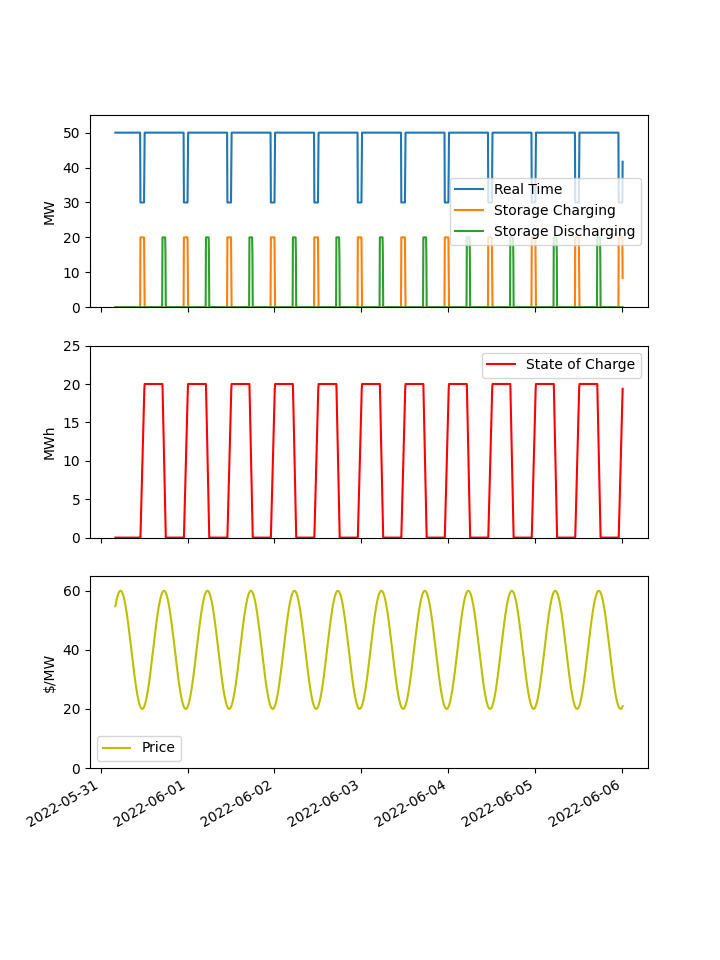

In [5]:
result_df['qRT'] = result_df['qNPP'] - result_df['qC']

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(7.2, 9.6))
ax[0].plot(result_df['Time'], result_df['qRT'], label='Real Time')
ax[0].plot(result_df['Time'], result_df['qC'], label='Storage Charging')
ax[0].plot(result_df['Time'], result_df['qD'], label='Storage Discharging')
ax[0].set_ylim(bottom=0, top=50.0+5)
ax[0].set_ylabel('MW')
ax[0].legend(loc=5)
ax[1].plot(result_df['Time'], result_df['SOC'], 'r', label='State of Charge')
ax[1].set_ylim(bottom=0, top=20+5)
ax[1].set_ylabel('MWh')
ax[1].legend()
ax[2].plot(result_df['Time'], result_df['LMP'], 'y', label='Price')
ax[2].set_ylim(bottom=0, top=result_df['LMP'].max()+5)
ax[2].set_ylabel('$/MW')
ax[2].legend()
fig.autofmt_xdate()